# iLINCS DiSignAtlas Overlap

## Overalp of DiSignAtlas with iLINCS

2024-01-30 16:44:15,649 - INFO - Retrieved a total of 1049/1084 GDS to GSE mappings
2024-01-30 16:44:35,879 - INFO - Retrieved a total of 0 iLINCS datasets


Error: 502 <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>502 Proxy Error</title>
</head><body>
<h1>Proxy Error</h1>
<p>The proxy server received an invalid
response from an upstream server.<br />
The proxy server could not handle the request<p>Reason: <strong>Error reading from remote server</strong></p></p>
</body></html>



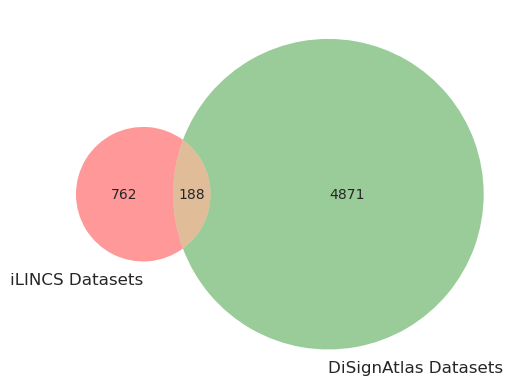

In [61]:
"""Overlap of DiSignAtlas w/ iLINCS

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Determine Overlap
    4. Plot Overlap
"""
# 1. Imports, Variables, Functions
# imports
import sys, os, pickle, logging, pandas as pd, numpy as np, requests
from tqdm import tqdm
import multiprocessing
from tqdm.contrib.concurrent import process_map
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
output_path_gds = os.path.join("..", "results", "files", "DiSignAtlas", "gds_2_gse.pkl")
iLINCS_filter = lambda s: (s["libraryid"] == "LIB_1")
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
output_path = os.path.join("..", "results", "files", "DiSignAtlas")

# functions


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    base_url = "http://www.ilincs.org/api"
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)
    base_url = "http://www.ilincs.org/api"
    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def process_dataset(dataset_id):
    # retrieve metadata from iLINCS for specific datasetid
    metadata = fetch_dataset_metadata(dataset_id)
    gds_id = metadata["SourceID"]
    return gds_id


# 2. Load Data
# load iLINCS GDS -> GSE mapping
# this was previously mapped using Entrez API ! ! ! (DiSignAtlas.ipynb)
with open(output_path_gds, "rb") as f:
    iLINCS_gds_2_gse = pickle.load(f)

logging.info(
    f"Retrieved a total of {len([k for k, v in iLINCS_gds_2_gse.items() if v.startswith('GSE')])}/{len(iLINCS_gds_2_gse)} GDS to GSE mappings"
)

# get iLINCS GSE ids
iLINCS_gse_ids = list(
    set([v for v in iLINCS_gds_2_gse.values() if v.startswith("GSE")])
)

# load iLINCS datasets
signatures = fetch_disease_signatures()
iLINCS_datasets = list(set([s["datasetid"] for s in signatures if iLINCS_filter(s)]))

logging.info(f"Retrieved a total of {len(iLINCS_datasets)} iLINCS datasets")


# load DiSignAtlas datasets
df_DS_data_info = pd.read_csv(data_info_path)
DS_gse_ids = df_DS_data_info["accession"].tolist()

# 3. Determine Overlap
# get gse ids for iLINCS datasets
common_gse_ids = list(set(iLINCS_gse_ids).intersection(set(DS_gse_ids)))

# 4. Plot Overlap
# Create the Venn diagram
venn2(
    [set(iLINCS_gse_ids), set(DS_gse_ids)],
    set_labels=("iLINCS Datasets", "DiSignAtlas Datasets"),
)

## Get Signatures for common datasets

In [62]:
"""Structure:
    1. Imports, Variables, Functions
    2. Map datasets to signatures
    3. Process iLINCS signatures
    4. Compute correlation between iLINCS and DiSignAtlas
"""

# 1. Imports, Variables, Functions
# imports
from scipy import stats

# variables
path_iLINCS_signature_info = os.path.join("..", "data", "iLINCS", "signatures.csv")
path_iLINCS_signatures = os.path.join(
    "..", "data", "iLINCS", "disease_signature_vectors.csv"
)

# functions


def get_iLINCS_signature_id(dataset_id, df_iLINCS_signature_info):
    """Load iLINCS Signatures and return all signature IDs for a given dataset ID.
    Arguments:
        - dataset_id(str): Dataset ID
    Returns:
        - list: List of signature IDs
    """

    # Filter for signatures where libraryid is 'LIB_1'
    df_iLINCS_disease_signatures = df_iLINCS_signature_info[
        df_iLINCS_signature_info["libraryid"] == "LIB_1"
    ]

    # Remove 'gds' prefix from dataset IDs and find matching signature IDs
    df_iLINCS_disease_signatures.loc[:, "datasetid"] = df_iLINCS_disease_signatures[
        "datasetid"
    ].apply(lambda x: x.replace("gds", ""))

    # Filter the DataFrame for rows with the given dataset ID
    filtered_df = df_iLINCS_disease_signatures[
        df_iLINCS_disease_signatures["datasetid"] == dataset_id
    ]

    # Return a list of signature IDs
    return (
        filtered_df["signatureid"].tolist(),
        filtered_df["level1"].tolist(),
        filtered_df["level2"].tolist(),
    )


def filter_ilincs_signature(l1, l2, key_words):
    if (l1 is not np.nan) and (any([k in l1.lower() for k in key_words])):
        return True
    elif (l2 is not np.nan) and (any([k in l2.lower() for k in key_words])):
        return True
    else:
        return False


def get_DiSignAtlas_signature(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    df = pd.read_csv(data_path, sep="\t")

    gene_ids = list()
    p_values = list()
    adj_p_values = list()
    de_values = list()
    for index, row in df.iterrows():
        # Handle cases where AdjPValue is 0
        # or nan values
        if (row["AdjPValue"] != 0) and (not np.isnan(row["AdjPValue"])):
            de_values.append(row["Log2FC"])
            p_values.append(row["PValue"])
            adj_p_values.append(row["AdjPValue"])
            gene_ids.append(row["GeneID"])

    # argsort()[::-1] returns the indices that would sort the array in descending order
    # argsort(argsort()[::-1]) then gives the ranks starting from 0, so we add 1 to start from 1
    ranking_p_values = (np.array(p_values).argsort()[::-1].argsort() + 1).tolist()
    ranking_adj_p_values = (
        np.array(adj_p_values).argsort()[::-1].argsort() + 1
    ).tolist()

    return (
        gene_ids,
        p_values,
        adj_p_values,
        ranking_p_values,
        ranking_adj_p_values,
        de_values,
    )


def sort_list_values(list_1, list_2, values_2):
    """Sort List Values - sort list_1 based on list_2 values.
    Arguments:
        - list_1(list): List to be sorted
        - list_2(list): List of values to sort by
        - values_2(list): List of values to return
    Returns:
        - sorted_values_2: Sorted list
    """
    list_2_values = dict(zip(list_2, values_2))
    sorted_values_2 = [list_2_values[i] for i in list_1]
    assert len(sorted_values_2) == len(list_1), "Err in sorting"
    return sorted_values_2


iLINCS_signatures_all = list()
iLINCS_l1s_all = list()
iLINCS_l2s_all = list()

DS_signatures_all = list()
DS_diseases_all = list()

# df iLINCS signatures
df_iLINCS_signature_info = pd.read_csv(path_iLINCS_signature_info, low_memory=False)

# iLINCS gse to gds
iLINCS_gse_2_gds = {v: k for k, v in iLINCS_gds_2_gse.items()}

# 2. Map datasets to signatures
# iterate through common gse ids
for gse_id in tqdm(common_gse_ids):
    # gds id
    gds_id = iLINCS_gse_2_gds[gse_id]

    # iLINCS signatures
    iLINCS_signature_ids, iLINCS_l1s, iLINCS_l2s = get_iLINCS_signature_id(
        gds_id, df_iLINCS_signature_info
    )
    iLINCS_signatures_all.append(iLINCS_signature_ids)
    iLINCS_l1s_all.append(iLINCS_l1s)
    iLINCS_l2s_all.append(iLINCS_l2s)

    # DiSignAtlas signatures
    DS_signatures = df_DS_data_info[df_DS_data_info["accession"] == gse_id][
        "dsaid"
    ].to_list()
    DS_diseases = df_DS_data_info[df_DS_data_info["accession"] == gse_id][
        "disease"
    ].to_list()
    DS_signatures_all.append(DS_signatures)
    DS_diseases_all.append(DS_diseases)

# 3. Process iLINCS signatures
# we are interested in signatures that correspond to control/normal/healthy
# differential expresions

# How many iLINCS signatures have control/normal/healthy conditions?
key_words = ["control", "normal", "healthy"]

# filtered iLINCS signatures
iLINCS_signatures_all_filtered = list()
iLINCS_l1s_all_filtered = list()
iLINCS_l2s_all_filtered = list()

for sublist_i, sublist_l1, sublist_l2 in zip(
    iLINCS_signatures_all, iLINCS_l1s_all, iLINCS_l2s_all
):
    i_found = list()
    l1_found = list()
    l2_found = list()
    for i, l1, l2 in zip(sublist_i, sublist_l1, sublist_l2):
        if filter_ilincs_signature(l1, l2, key_words):
            i_found.append(i)
            l1_found.append(l1)
            l2_found.append(l2)
    iLINCS_signatures_all_filtered.append(i_found)
    iLINCS_l1s_all_filtered.append(l1_found)
    iLINCS_l2s_all_filtered.append(l2_found)

# 4. Compute correlation between iLINCS and DiSignAtlas
# load large iLINCS dataframe
df_iLINCS_signatures = pd.read_csv(path_iLINCS_signatures)

logging.info(f"Loaded df {df_iLINCS_signatures.shape} iLINCS signatures")

100%|██████████| 188/188 [00:01<00:00, 102.84it/s]
2024-01-30 16:45:25,151 - INFO - Loaded df (144545011, 6) iLINCS signatures


In [63]:
def get_iLINCS_signatures(iLINCS_signature_id):
    """Get iLINCS Signatures for a given signature ID.
    Arguments:
        - iLINCS_signature_id(str): iLINCS Signature ID
    Returns:
        - gene_ids(list): List of gene IDs
        - p_values(list): List of p-values
        - de_values(list): List of log2 fold changes
    """
    iLINCS_signatures_path = os.path.join("..", "data", "iLINCS", "signature_vectors")
    df = pd.read_csv(os.path.join(iLINCS_signatures_path, iLINCS_signature_id + ".csv"))

    gene_ids = df["ID_geneid"].to_list()
    de_values = df["Value_LogDiffExp"].to_list()
    p_values = df["Significance_pvalue"].to_list()

    return gene_ids, de_values, p_values

In [64]:
# store results
des_correlations = list()
p_value_correlations = list()
adj_p_value_correlations = list()

# iterate through common gse ids
for index, gse_id in tqdm(enumerate(common_gse_ids), total=len(common_gse_ids)):
    # get gds id
    gds_id = iLINCS_gse_2_gds[gse_id]

    # get iLINCS signature ids
    iLINCS_signature_ids = iLINCS_signatures_all_filtered[index]
    if len(iLINCS_signature_ids) == 0:
        continue

    # store results in sublist for each gse_id
    des_correlations_sublist = list()
    p_value_correlations_sublist = list()
    adj_p_value_correlations_sublist = list()

    # store in each iteration signatures for each dataset
    iLINCS_gene_ids = list()
    iLINCS_des = list()
    iLINCS_pvalues = list()
    for iLINCS_signature_id in iLINCS_signature_ids:
        # get iLINCS signatures
        iLINCS_gene_id, iLINCS_de, iLINCS_pvalue = get_iLINCS_signatures(
            iLINCS_signature_id
        )

        iLINCS_gene_ids.append(iLINCS_gene_id)
        iLINCS_des.append(iLINCS_de)
        iLINCS_pvalues.append(iLINCS_pvalue)

    # get DiSignAtlas signatures
    DS_signatures = DS_signatures_all[index]

    # store in each iteration signatures for each dataset
    DS_gene_ids = list()
    DS_des = list()
    DS_pvalues = list()
    DS_adj_pvalues = list()
    for DS_signature in DS_signatures:
        # get DiSignAtlas signatures
        (
            DiSginAtlas_genes,
            DiSginAtlas_pvalue,
            DiSginAtlas_adj_pvalue,
            DiSginAtlas_ranking_pvalue,
            DiSginAtlas_ranking_adj_pvalue,
            DiSginAtlas_de,
        ) = get_DiSignAtlas_signature(DS_signature)
        DS_gene_ids.append(DiSginAtlas_genes)
        DS_des.append(DiSginAtlas_de)
        DS_pvalues.append(DiSginAtlas_pvalue)
        DS_adj_pvalues.append(DiSginAtlas_adj_pvalue)

    # compare each iLINCS signature with each DiSignAtlas signature
    for index_1 in range(len(iLINCS_signature_ids)):
        for index_2 in range(len(DS_signatures)):
            common_genes = list(
                set(iLINCS_gene_ids[index_1]).intersection(set(DS_gene_ids[index_2]))
            )
            sorted_iLINCS_pvalues = sort_list_values(
                common_genes,
                iLINCS_gene_ids[index_1],
                iLINCS_pvalues[index_1],
            )
            sorted_iLINCS_des = sort_list_values(
                common_genes,
                iLINCS_gene_ids[index_1],
                iLINCS_des[index_1],
            )
            sorted_DS_pvalues = sort_list_values(
                common_genes,
                DS_gene_ids[index_2],
                DS_pvalues[index_2],
            )
            sorted_DS_adj_pvalues = sort_list_values(
                common_genes,
                DS_gene_ids[index_2],
                DS_adj_pvalues[index_2],
            )
            sorted_DS_des = sort_list_values(
                common_genes,
                DS_gene_ids[index_2],
                DS_des[index_2],
            )

            # compute correlations
            des_correlations_sublist.append(
                stats.pearsonr(sorted_iLINCS_pvalues, sorted_DS_pvalues)
            )
            p_value_correlations_sublist.append(
                stats.pearsonr(sorted_iLINCS_des, sorted_DS_des)
            )
            adj_p_value_correlations_sublist.append(
                stats.pearsonr(sorted_iLINCS_pvalues, sorted_DS_adj_pvalues)
            )
    des_correlations.append(des_correlations_sublist)
    p_value_correlations.append(p_value_correlations_sublist)
    adj_p_value_correlations.append(adj_p_value_correlations_sublist)

 22%|██▏       | 42/188 [00:30<01:13,  2.00it/s]/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 41%|████▏     | 78/188 [00:49<00:57,  1.91it/s]/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 84%|████████▎ | 157/188 [01:48<00:26,  1.16it/s]/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 188/188 [02:09<00:00,  1.45it/s]


In [65]:
# plot correlations
des_correlations_processed = [
    item[0] for sublist in des_correlations for item in sublist
]
p_value_correlations_processed = [
    item[0] for sublist in p_value_correlations for item in sublist
]
adj_p_value_correlations_processed = [
    item[0] for sublist in adj_p_value_correlations for item in sublist
]

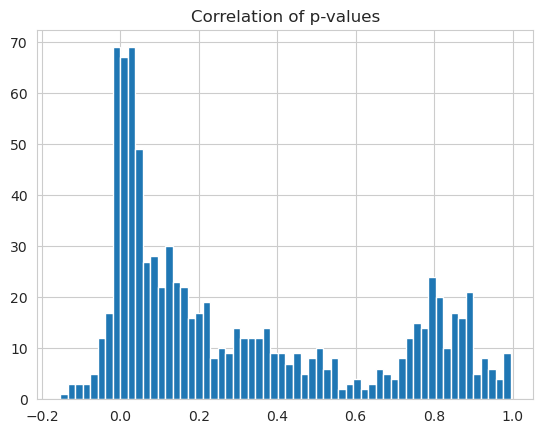

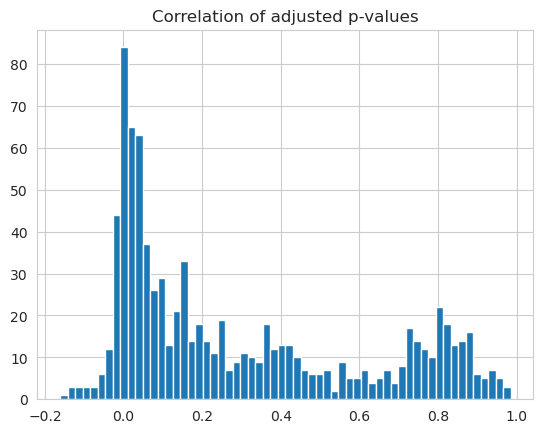

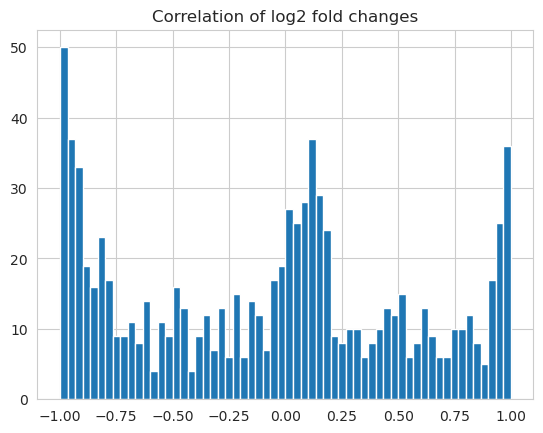

In [66]:
# plot histogram of correlations
plt.hist(des_correlations_processed, bins=60)
plt.title("Correlation of p-values")
plt.show()

# plot histogram of correlations
plt.hist(adj_p_value_correlations_processed, bins=60)
plt.title("Correlation of adjusted p-values")
plt.show()

# plot histogram of correlations
plt.hist(p_value_correlations_processed, bins=60)
plt.title("Correlation of log2 fold changes")
plt.show()

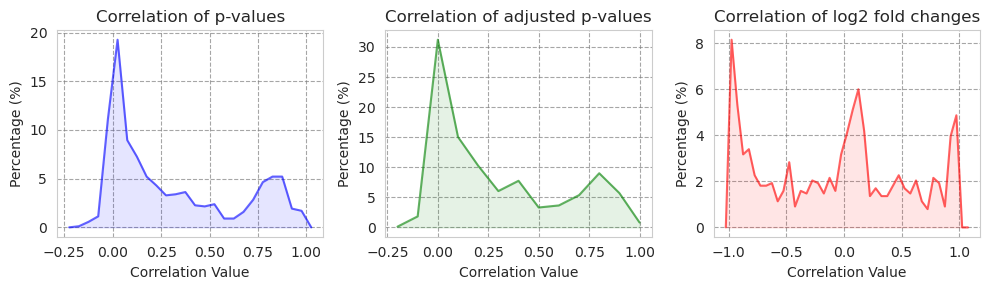

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom bin widths and ranges for each dataset
bin_widths = [0.05, 0.1, 0.05]
bin_ranges = [(-0.25, 1.05), (-0.25, 1.05), (-1.05, 1.05)]

# Dataset 1: Correlation of p-values
bins = np.arange(bin_ranges[0][0], bin_ranges[0][1] + bin_widths[0], bin_widths[0])
counts, _ = np.histogram(des_correlations_processed, bins=bins)
percent_counts = counts * 100 / counts.sum()
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(bin_centers, percent_counts, color="blue", alpha=0.6)
plt.fill_between(bin_centers, percent_counts, color="blue", alpha=0.1)
plt.grid(color="grey", linestyle="--", alpha=0.7)
plt.title("Correlation of p-values")
plt.xlabel("Correlation Value")
plt.ylabel("Percentage (%)")

# Dataset 2: Correlation of adjusted p-values
bins = np.arange(bin_ranges[1][0], bin_ranges[1][1] + bin_widths[1], bin_widths[1])
counts, _ = np.histogram(adj_p_value_correlations_processed, bins=bins)
percent_counts = counts * 100 / counts.sum()
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.subplot(1, 3, 2)
plt.plot(bin_centers, percent_counts, color="green", alpha=0.6)
plt.fill_between(bin_centers, percent_counts, color="green", alpha=0.1)
plt.grid(color="grey", linestyle="--", alpha=0.7)
plt.title("Correlation of adjusted p-values")
plt.xlabel("Correlation Value")
plt.ylabel("Percentage (%)")

# Dataset 3: Correlation of log2 fold changes
bins = np.arange(bin_ranges[2][0], bin_ranges[2][1] + bin_widths[2], bin_widths[2])
counts, _ = np.histogram(p_value_correlations_processed, bins=bins)
percent_counts = counts * 100 / counts.sum()
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.subplot(1, 3, 3)
plt.plot(bin_centers, percent_counts, color="red", alpha=0.6)
plt.fill_between(bin_centers, percent_counts, color="red", alpha=0.1)
plt.grid(color="grey", linestyle="--", alpha=0.7)
plt.title("Correlation of log2 fold changes")
plt.xlabel("Correlation Value")
plt.ylabel("Percentage (%)")

plt.tight_layout()
plt.savefig(
    os.path.join(output_path, "correlation_iLINCS_DiSignAtlas.png"),
    dpi=300,
    bbox_inches="tight",
)